In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import random as rd
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras import losses
from keras import optimizers
from keras import metrics
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose
from keras.models import Sequential

In [3]:
import os

paths = []  # Creating a list for paths

for r, d, f in os.walk(r'/content/gdrive/MyDrive/Brain_MRI_images'):
    for file in f:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            paths.append(os.path.join(r, file))

subset_paths = paths[:2000]
print(len(subset_paths))

train_df,valid_df=train_test_split(subset_paths,test_size=0.2,random_state=42)


2000


In [4]:
test_df=paths[2500:2800]
len(test_df)

300

In [5]:
# Function to load and preprocess the image
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (240, 240))
    img = img.astype("float32") / 255.0
    img_noisy = 0.3* np.random.normal(0, 1, size=(240,240)) + img
    img_noisy=np.clip(img_noisy,0,1)
    return img,img_noisy


# Load and preprocess images
trainset = [load_image(path)[0] for path in train_df]
validset = [load_image(path)[0] for path in valid_df]

trainset_noisy = [load_image(path)[1] for path in train_df]
validset_noisy = [load_image(path)[1] for path in valid_df]

# Convert the list of processed images to a NumPy array
trainset = np.array(trainset)
trainset_noisy = np.array(trainset_noisy)
validset = np.array(validset)
validset_noisy = np.array(validset_noisy)



# Convert NumPy array to TensorFlow tensor
trainset = tf.convert_to_tensor(trainset)
vaildset = tf.convert_to_tensor(validset)


trainset_noisy = tf.convert_to_tensor(trainset_noisy)
vaildset_noisy = tf.convert_to_tensor(validset_noisy)




In [ ]:
# # Define augmentation functions
# def augment_data(clean_image, noisy_image):
#     noisy_image = tf.image.random_flip_left_right(noisy_image)
#     clean_image = tf.image.random_flip_left_right(clean_image)
#     noisy_image = tf.image.random_flip_up_down(noisy_image)
#     clean_image = tf.image.random_flip_up_down(clean_image)
#     noisy_image = tf.image.random_contrast(noisy_image, lower=0.5, upper=1.5)
#     clean_image = tf.image.random_contrast(clean_image, lower=0.5, upper=1.5)
#     noisy_image = tf.image.random_brightness(noisy_image, max_delta=0.1)
#     clean_image = tf.image.random_brightness(clean_image, max_delta=0.1)
#     noisy_image = tf.image.random_saturation(noisy_image, lower=0.5, upper=1.5)
#     clean_image = tf.image.random_saturation(clean_image, lower=0.5, upper=1.5)
#     return clean_image, noisy_image

# # Apply augmentation to the dataset
# trainset_augmented, trainset_noisy_augmented = augment_data(trainset, trainset_noisy)
# validset_augmented, validset_noisy_augmented = augment_data(validset, validset_noisy)

In [6]:
testset = [load_image(path)[0] for path in test_df]
testset_noisy = [load_image(path)[1] for path in test_df]

testset = np.array(testset)
testset_noisy = np.array(testset_noisy)

testset = tf.convert_to_tensor(testset)
testset_noisy = tf.convert_to_tensor(testset_noisy)

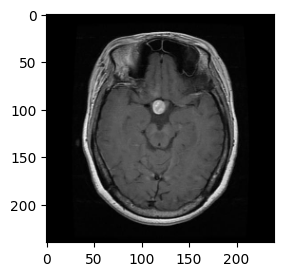

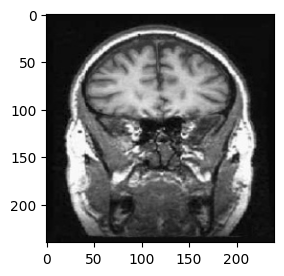

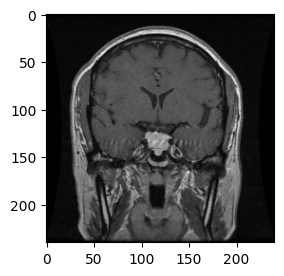

In [7]:
for i in range(3):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,3,i+1)
    plt.imshow(trainset[i],cmap="gray")

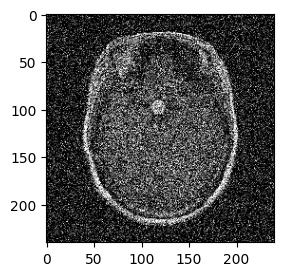

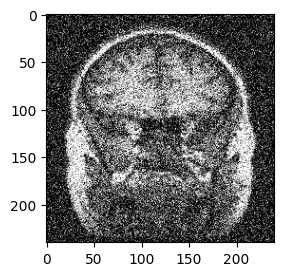

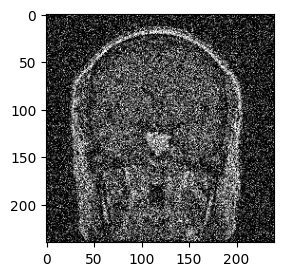

In [8]:
for i in range(3):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,3,i+1)
    plt.imshow(trainset_noisy[i],cmap="gray")

In [9]:
# input_img = (240,240,1)

# model= Sequential([

#                     # encoder network
#                     Conv2D(32, 3, activation='relu', padding='same', input_shape=input_img),
#                     MaxPooling2D(2, padding='same'),
#                     Conv2D(32, 3, activation='relu', padding='same'),
#                     MaxPooling2D(2, padding='same'),
#                     # decoder network
#                     Conv2D(32, 3, activation='relu', padding='same'),
#                     UpSampling2D(2),
#                     Conv2D(32, 3, activation='relu', padding='same'),
#                     UpSampling2D(2),
#                     # output layer
#                     Conv2D(1, 3, activation='sigmoid', padding='same')
# ])

# model.compile(optimizer='adam', loss = 'mean_squared_error')
# model.summary()

In [10]:
#Model with more layers

input_img = (240, 240, 1)

model = Sequential([
    # Encoder
    Conv2D(32, 3, activation='relu', padding='same', input_shape=input_img),
    MaxPooling2D(2, padding='same'),

    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPooling2D(2, padding='same'),

    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(2, padding='same'),

    # Bottleneck - reduced dimension representation

    # Decoder
    Conv2D(128, 3, activation='relu', padding='same'),
    UpSampling2D(2),

    Conv2D(64, 3, activation='relu', padding='same'),
    UpSampling2D(2),

    Conv2D(32, 3, activation='relu', padding='same'),
    UpSampling2D(2),

    # Output layer
    Conv2D(1, 3, activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 240, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 120, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

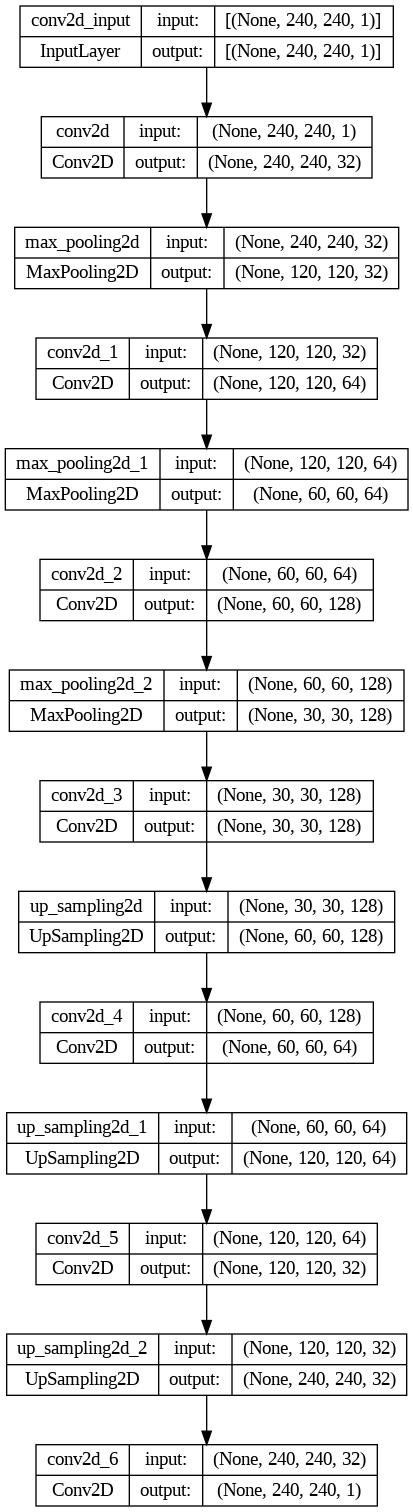

In [11]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath to save the best model
filepath = 'best_model.h5'

# Initialize ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Training the model with the callback
history = model.fit(
    x=trainset_noisy,
    y=trainset,
    validation_data=(validset_noisy, validset),
    batch_size=64,
    epochs=200,
    callbacks=[callback, checkpoint]  # Add ModelCheckpoint to the list of callbacks
)


Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.01860, saving model to best_model.h5
25/25 [==============================] - 18s 291ms/step - loss: 0.0462 - val_loss: 0.0186
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0150
Epoch 2: val_loss improved from 0.01860 to 0.01158, saving model to best_model.h5
25/25 [==============================] - 6s 238ms/step - loss: 0.0150 - val_loss: 0.0116
Epoch 3/200
25/25 [==============================] - ETA: 0s - loss: 0.0120
Epoch 3: val_loss improved from 0.01158 to 0.00998, saving model to best_model.h5
25/25 [==============================] - 6s 241ms/step - loss: 0.0120 - val_loss: 0.0100
Epoch 4/200
25/25 [==============================] - ETA: 0s - loss: 0.0094
Epoch 4: val_loss improved from 0.00998 to 0.00866, saving model to best_model.h5
25/25 [==============================] - 6s 243ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 5/200
25/25 [==============================] - ETA: 0s - loss: 0.0086
Epoch 5: val_loss improved from 0.00866 to 0.00775, saving model to best_model.h5
25/25 [==============================] - 6s 241ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 6/200
25/25 [=====

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the filepath to save the best model
# filepath = 'best_model.keras'

# # Initialize ModelCheckpoint callback
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # Training the model with the callback
# history = model.fit(
#     x=trainset_noisy_augmented,
#     y=trainset_augmented,
#     validation_data=(validset_noisy_augmented, validset_augmented),
#     batch_size=64,
#     epochs=200,
#     callbacks=[callback, checkpoint]  # Add ModelCheckpoint to the list of callbacks
# )


In [14]:
history.history??

In [15]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

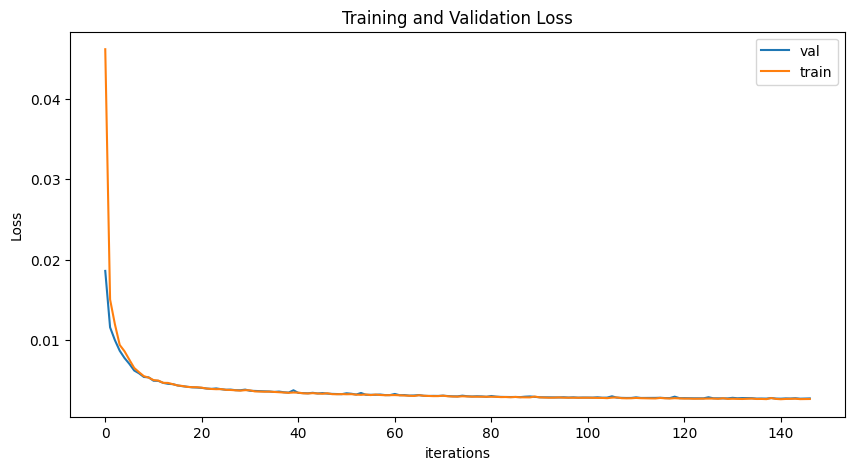

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(history.history["val_loss"],label="val")
plt.plot(history.history["loss"],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model('best_model.h5')

#testing a single image
img = testset_noisy[0]
img = np.expand_dims(img, axis=0)  # Add a batch dimension for the single image

predicted_image = best_model.predict(img)



1/1 [==============================] - 0s 291ms/step


shape of test data: (300, 240, 240, 1)


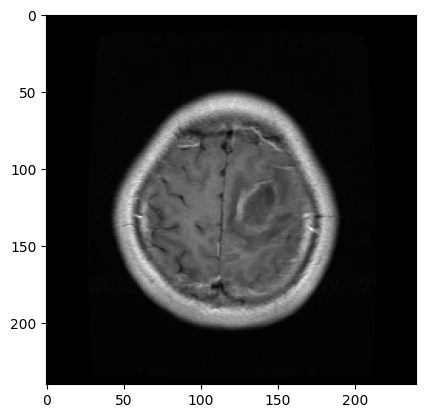

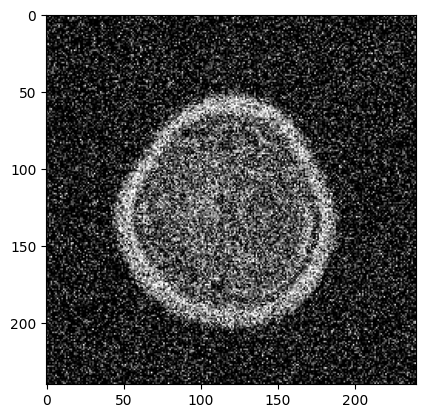

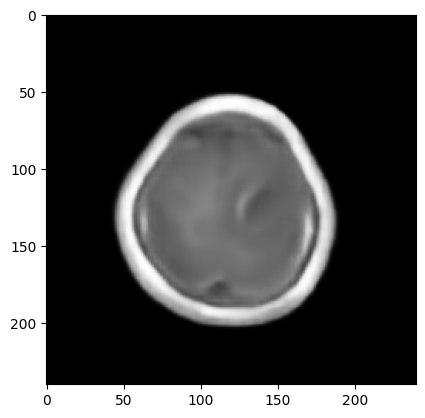

In [18]:
#complete test data
pred = model(testset)
print("shape of test data:",pred.shape)
plt.imshow(testset[3],cmap="gray")
plt.show()
plt.imshow(testset_noisy[3],cmap="gray")
plt.show()
plt.imshow(pred[3],cmap="gray")
plt.show()


In [19]:
testset[0].shape # = testset.numpy()

TensorShape([240, 240])

In [20]:
predicted_image[0].shape

(240, 240, 1)

In [21]:
testset=np.array(testset)
pred=np.array(pred)
# print(testset.shape)
# print(testset[0].dtype)
# print(predicted_image.reshape(240,240).dtype)
print(structural_similarity(testset[0],predicted_image[0].reshape(240,240)))

0.840596146251429


In [22]:
# print(pred[0].reshape(240,240))

In [23]:
ssim1=0
for i in range(len(testset)):
  ssim1+=structural_similarity(testset[i],pred[i].reshape(240,240))
ssim=ssim1/len(testset)
print(ssim)

0.7882484515522875


In [24]:
psnr1=0
for i in range(len(testset)):
  psnr1+=peak_signal_noise_ratio(testset[i],pred[i].reshape(240,240))
psnr=psnr1/len(testset)
print(psnr)

24.596448272114362
